### 10-701 Machine Learning Project
# Image Caption Generation

Team 26  
Olivier Filion  
Michael Agaby  
Nicholas Amano  

All Imports: I'm copy pasting all imports here to stay organized

In [ ]:
import sys
print(sys.version)
import json
import os
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


## Utility Functions

In [2]:
import json
import os

def load_captions(path):
    with open(path, "r") as json_file:
        json_dict = json.load(json_file)
    captions = {}
    for annotation in json_dict["annotations"]:
        image_id = annotation["image_id"]
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(annotation["caption"])
    return captions

train_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_train2017.json"))
val_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_val2017.json"))
print(val_captions[139]) 

['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']


In [3]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")
def preprocess_captions(captions):
    preprocessed_captions = {}
    for image_id in captions:
        preprocessed_captions[image_id] = []
        for caption in captions[image_id]:
            caption = "<start> " + caption.lower().strip() + " <end>"
            caption = tokenizer(caption)
            preprocessed_captions[image_id].append(caption)
    return preprocessed_captions

preprocessed_train_captions = preprocess_captions(train_captions)
preprocessed_val_captions = preprocess_captions(val_captions)
print(preprocessed_val_captions[139])

[['<start>', 'a', 'woman', 'stands', 'in', 'the', 'dining', 'area', 'at', 'the', 'table', '.', '<end>'], ['<start>', 'a', 'room', 'with', 'chairs', ',', 'a', 'table', ',', 'and', 'a', 'woman', 'in', 'it', '.', '<end>'], ['<start>', 'a', 'woman', 'standing', 'in', 'a', 'kitchen', 'by', 'a', 'window', '<end>'], ['<start>', 'a', 'person', 'standing', 'at', 'a', 'table', 'in', 'a', 'room', '.', '<end>'], ['<start>', 'a', 'living', 'area', 'with', 'a', 'television', 'and', 'a', 'table', '<end>']]


In [4]:
from torchtext.vocab import build_vocab_from_iterator

def create_vocabulary(tokenized_captions):
    all_tokens = []
    for image_id in tokenized_captions:
        for caption in tokenized_captions[image_id]:
            all_tokens += caption
    return build_vocab_from_iterator([all_tokens], min_freq=1, specials=["<unk>"])

vocabulary = create_vocabulary(preprocessed_train_captions)
print(len(vocabulary))

28939


In [5]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class CaptionDataset(Dataset):

    def __init__(self, image_folder, preprocessed_captions, vocab):
        self.image_folder = image_folder
        self.captions = preprocessed_captions
        self.vocab = vocab
        self.indices = [(image_id, caption_id)
                        for image_id in preprocessed_captions
                        for caption_id in range(len(preprocessed_captions[image_id]))]
        self.transform = ToTensor()
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_id, caption_id = self.indices[idx]
        
        image_str = str(image_id)
        image_filename = "0" * (12 - len(image_str)) + image_str + ".jpg"
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path)
        image_tensor = self.transform(image)

        caption = self.captions[image_id][caption_id]
        labels = torch.zeros((len(caption), 1))
        for i, token in enumerate(caption):
            token = token if token in self.vocab else "<unk>"
            labels[i][0] = self.vocab[token]

        return image_tensor, labels
  

## Visualizing Some Data

torch.Size([3, 400, 400])
tensor([[3.0000e+00],
        [1.0000e+00],
        [3.5700e+02],
        [3.8150e+03],
        [9.0000e+00],
        [1.0000e+00],
        [8.4000e+01],
        [1.2300e+02],
        [7.0000e+00],
        [4.1000e+01],
        [1.0860e+03],
        [4.0000e+00],
        [2.0000e+00]])
['<start>', 'a', 'bicycle', 'replica', 'with', 'a', 'clock', 'as', 'the', 'front', 'wheel', '.', '<end>']


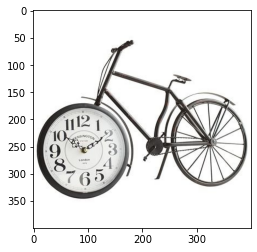

In [6]:
import matplotlib.pyplot as plt

train_ds = CaptionDataset(os.path.join("dataset", "train", "train2017"), preprocessed_train_captions, vocabulary)

im, l = train_ds[0]
print(im.shape)
print(l)

print(preprocessed_train_captions[train_ds.indices[0][0]][train_ds.indices[0][1]])

plt.imshow(im.permute((1, 2, 0)))
plt.show()

['<start>', 'a', 'car', 'that', 'seems', 'to', 'be', 'parked', 'illegally', 'behind', 'a', 'legally', 'parked', 'car', '<end>']
['<start>', 'two', 'cars', 'parked', 'on', 'the', 'sidewalk', 'on', 'the', 'street', '<end>']
['<start>', 'city', 'street', 'with', 'parked', 'cars', 'and', 'a', 'bench', '.', '<end>']
['<start>', 'cars', 'try', 'to', 'maneuver', 'into', 'parking', 'spaces', 'along', 'a', 'densely', 'packed', 'city', 'street', '.', '<end>']
['<start>', 'a', 'couple', 'of', 'cars', 'parked', 'in', 'a', 'busy', 'street', 'sidewalk', '.', '<end>']


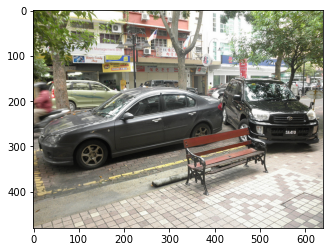

In [8]:
# an example of all 5 captions for one image
im, l = train_ds[10]
print(preprocessed_train_captions[train_ds.indices[10][0]][0])
print(preprocessed_train_captions[train_ds.indices[10][0]][1])
print(preprocessed_train_captions[train_ds.indices[10][0]][2])
print(preprocessed_train_captions[train_ds.indices[10][0]][3])
print(preprocessed_train_captions[train_ds.indices[10][0]][4])
plt.imshow(im.permute((1, 2, 0)))
plt.show()

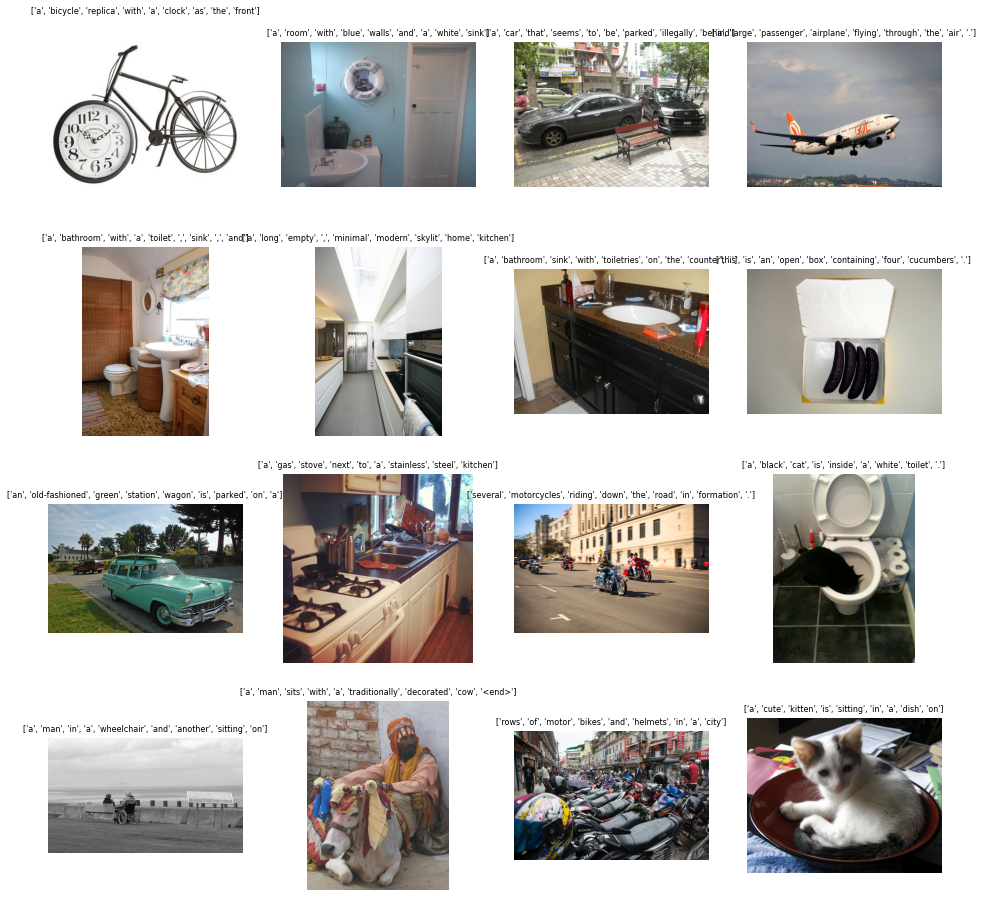

In [29]:
# 16 images as well as the first few wordsw of one of their captions
plt.subplots(figsize=(16,16))

for i in range(16):
    im, l = train_ds[5*i]
    plt.subplot(4,4,i+1)
    plt.title(preprocessed_train_captions[train_ds.indices[5*i][0]][0][1:10], fontsize=8)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()